### Imports

In [18]:
%pip install yfinance
%pip install matplotlib
%pip install scikit-learn
%pip install lxml

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 86.1 MB/s  0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=aecd7dde22bb0f230622176c030cf54ff9be9939895d020742250ed874fe0708
  Stored in directory: /home/onyxia/.cache/pip/wheels/1e/df/0f/e2bbb22d689b30c681feb5410ab64a2523437b34c8ecfc6476
Successfully built multitasking
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [yfinance]5/6 [yfinance]]]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 75.9 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import numpy as np
import pickle as pk
import requests
import copy
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression

## Data collection

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers)
SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()
SPY_tickers.append("^GSPC")

NameError: name 'requests' is not defined

In [4]:
data = yf.download(SPY_tickers, start="2000-01-01", end="2025-11-25", auto_adjust=True)

[                       1%                       ]  6 of 504 completed

[**********************57%**                     ]  286 of 504 completed$BRK.B: possibly delisted; no timezone found
[**********************87%*****************      ]  439 of 504 completed$BF.B: possibly delisted; no price data found  (1d 2000-01-01 -> 2025-11-25)
[*********************100%***********************]  504 of 504 completed

6 Failed downloads:
['BMY']: OperationalError('database is locked')
['MSI', 'ADI', 'DD']: TypeError("'NoneType' object is not subscriptable")
['BRK.B']: possibly delisted; no timezone found
['BF.B']: possibly delisted; no price data found  (1d 2000-01-01 -> 2025-11-25)


In [5]:
data.to_parquet("data/SPY_data.pq")

## Dataset creation

In [6]:
data = pd.read_parquet("data/SPY_data.pq")

In [3]:
# selected_stocks = data['Close'].columns.unique()[(data['Close'].isna().mean()<0.1)]

In [4]:
# len(selected_stocks)

In [7]:
data.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [8]:
log_close = np.log(data['Close'])
log_open  = np.log(data['Open'])
log_high  = np.log(data['High'])
log_low   = np.log(data['Low'])

stocks = data['Close'].columns.unique()[:-1]
# stocks = selected_stocks[:-1]
index = '^GSPC'

# --- returns ---
close_diff = log_close[stocks].diff()
index_ret  = log_close[index].diff()

df = close_diff.mul(1e4).stack().rename("close_1d_ret").reset_index()

df["close_1d_ret_hedged"] = (
    (close_diff.sub(index_ret, axis=0) * 1e4)
    .stack()
    .values
)

# --- open-close ---
open_close = (log_close[stocks] - log_open[stocks]) * 1e4
open_close_idx = (log_close[index] - log_open[index]) * 1e4

df = df.merge(
    open_close.stack().rename("open_close_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (open_close.sub(open_close_idx, axis=0))
        .stack()
        .rename("open_close_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- close-open ---

close_open = (log_open[stocks] - log_close[stocks].shift()) * 1e4
close_open_idx = (log_open[index] - log_close[index].shift()) * 1e4

df = df.merge(
    close_open.stack().rename("close_open_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (close_open.sub(close_open_idx, axis=0))
        .stack()
        .rename("close_open_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- high-low ---
high_low = (log_high[stocks] - log_low[stocks]) * 1e4
high_low_idx = (log_high[index] - log_low[index]) * 1e4

df = df.merge(
    high_low.stack().rename("high_low_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (high_low.sub(high_low_idx, axis=0))
        .stack()
        .rename("high_low_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- volumes ---
volume = data['Volume'][stocks]
dollar_volume = volume * (data['Open'][stocks] + data['Close'][stocks])/2
dolar_volume_share = volume.div(volume.sum(axis=1), axis=0)

df = df.merge(
    volume.stack().rename("volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dollar_volume.stack().rename("dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dolar_volume_share.stack().rename("share_dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

In [9]:
df['body_ratio'] = df['open_close_ret'] / (df['high_low_ret']+1e-8)

In [10]:
df['turnover_proxy'] = df['dollar_volume'] / df.groupby('Date')['dollar_volume'].transform('mean')

In [11]:
df.set_index('Date', inplace=True)

In [12]:
df['close_1d_ret_lag1'] = df.groupby('Ticker')['close_1d_ret'].shift()
df['close_1d_ret_hedged_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged'].shift()
df['open_close_ret'] = df.groupby('Ticker')['open_close_ret'].shift()
df['open_close_ret_hedged'] = df.groupby('Ticker')['open_close_ret_hedged'].shift()
df['close_open_ret'] = df.groupby('Ticker')['close_open_ret'].shift()
df['close_open_ret_hedged'] = df.groupby('Ticker')['close_open_ret_hedged'].shift()
df['high_low_ret'] = df.groupby('Ticker')['high_low_ret'].shift()
df['high_low_ret_hedged'] = df.groupby('Ticker')['high_low_ret_hedged'].shift()
df['share_dollar_volume'] = df.groupby('Ticker')['share_dollar_volume'].shift()
df['body_ratio'] = df.groupby('Ticker')['body_ratio'].shift()
df['turnover_proxy'] = df.groupby('Ticker')['turnover_proxy'].shift()

In [13]:
df.tail()

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,dollar_volume,share_dollar_volume,body_ratio,turnover_proxy,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,
2025-11-24,XYZ,-14.538433,-168.026622,-102.779030,-174.549343,102.779030,76.798313,551.886861,342.305225,7393600.0,4.579411e+08,0.003245,-0.186232,0.731647,0.000000,-97.751030
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,5.535747e+08,0.000613,0.884709,0.334742,249.524614,151.773584
2025-11-24,ZBH,144.320589,-9.167600,297.280165,225.509851,45.926550,19.945833,398.187759,188.606124,2779100.0,2.587412e+08,0.000634,0.746583,0.208053,343.206715,245.455684
2025-11-24,ZBRA,62.060605,-91.427584,370.765291,298.994977,164.144503,138.163786,552.874732,343.293096,930100.0,2.251958e+08,0.000284,0.670614,0.243013,534.909794,437.158763
2025-11-24,ZTS,66.142011,-87.346178,476.520315,404.750001,42.192155,16.211439,533.773332,324.191696,7826900.0,9.568385e+08,0.001584,0.892739,0.683883,518.712470,420.961440


In [14]:
linear_features = ['close_1d_ret_lag1', 'close_1d_ret_hedged_lag1', 'open_close_ret', 'open_close_ret_hedged', 'close_open_ret', 'close_open_ret_hedged', 'high_low_ret', 'high_low_ret_hedged', 'body_ratio']
non_linear_features = ['share_dollar_volume', 'turnover_proxy']

In [15]:
with open("linear_features.pkl", "wb") as f:
    pk.dump(linear_features, f)

with open("non_linear_features.pkl", "wb") as f:
    pk.dump(non_linear_features, f)

In [16]:
df

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,dollar_volume,share_dollar_volume,body_ratio,turnover_proxy,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,
2000-01-04,A,-794.644473,-403.652719,NaN,NaN,NaN,NaN,NaN,NaN,4765083.0,1.917209e+08,NaN,NaN,NaN,NaN,NaN
2000-01-04,AAPL,-880.774130,-489.782377,NaN,NaN,NaN,NaN,NaN,NaN,512377600.0,4.048177e+08,NaN,NaN,NaN,NaN,NaN
2000-01-04,ABT,-289.872231,101.119523,NaN,NaN,NaN,NaN,NaN,NaN,10734887.0,8.536908e+07,NaN,NaN,NaN,NaN,NaN
2000-01-04,ACGL,-54.500128,336.491626,NaN,NaN,NaN,NaN,NaN,NaN,84600.0,1.019541e+05,NaN,NaN,NaN,NaN,NaN
2000-01-04,ADBE,-876.181853,-485.190099,NaN,NaN,NaN,NaN,NaN,NaN,7813200.0,1.193387e+08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24,XYZ,-14.538433,-168.026622,-102.779030,-174.549343,102.779030,76.798313,551.886861,342.305225,7393600.0,4.579411e+08,0.003245,-0.186232,0.731647,0.000000,-97.751030
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,5.535747e+08,0.000613,0.884709,0.334742,249.524614,151.773584
2025-11-24,ZBH,144.320589,-9.167600,297.280165,225.509851,45.926550,19.945833,398.187759,188.606124,2779100.0,2.587412e+08,0.000634,0.746583,0.208053,343.206715,245.455684


In [17]:
df.to_parquet('df_base.pq')

# Feature list
1. Avg past returns close to close
2. Avg past returns open to close
3. Avg past returns low to close
4. Avg past returns high to low

- Hedged/Not hedged
- Clipped/Not clipped

# Models list

## Baseline
1. Random
2. Past returns (define period)
3. MACD vol adjusted
4. Linear Regression (define features + beta)

## LTR
1. LambdaMART (pairwise)
2. LambdaRANK (listwise)
3. ListMLE (listwise - use LightGBM)

# Baseline models

## Random Strategy

In [18]:
df = pd.read_parquet('df_base.pq')

In [19]:
np.random.seed(42)
df['random_signal'] = 0.0

def assign_random_signals(group):
    n = len(group)
    if n >= 70:
        signals = np.array([1.0] * 35 + [-1.0] * 35 + [0.0] * (n - 70))
        np.random.shuffle(signals)
        return pd.Series(signals, index=group.index)
    else:
        return pd.Series(0.0, index=group.index)

df['random_signal'] = df.groupby('Date', group_keys=False).apply(assign_random_signals)

In [20]:
random_daily_returns = df.groupby('Date').apply(lambda x: (x['random_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

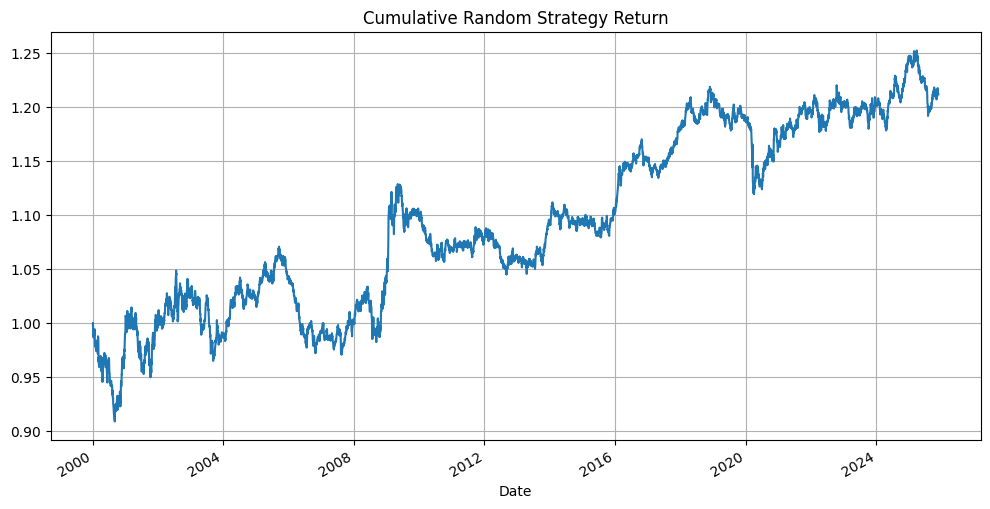

In [21]:
(random_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [22]:
random_daily_returns.mean()/random_daily_returns.std()*np.sqrt(252)

np.float64(0.21580421264586783)

## Momentum Strategies

In [23]:
df = pd.read_parquet('df_base.pq')

### Simple Momentum Strategy

In [24]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0))
    return signal

In [25]:
df['momentum_signal'] = df.groupby('Date')['close_1d_ret_lag1'].transform(compute_signal)

In [26]:
momentum_daily_returns = df.groupby('Date').apply(
    lambda x: (x['momentum_signal'] * x['close_1d_ret']).sum()/70
)*1e-4

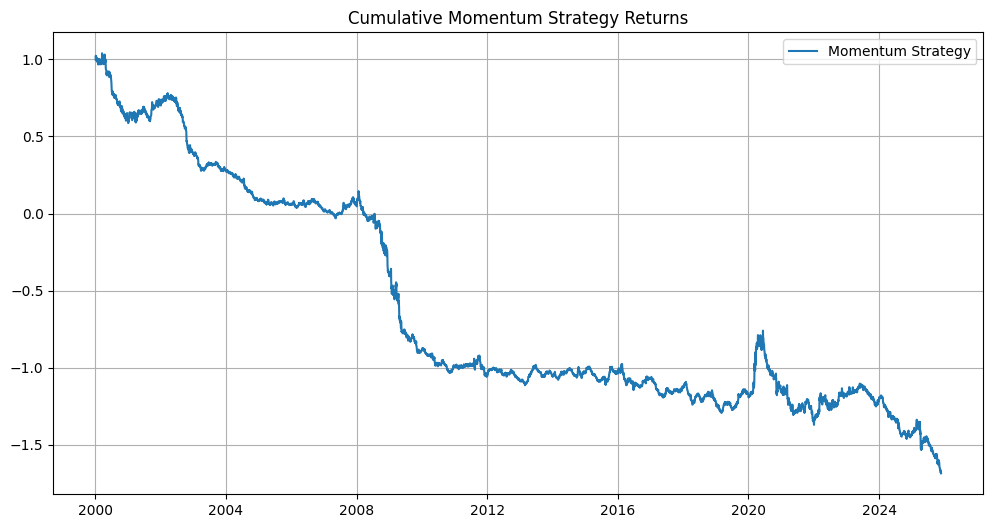

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(momentum_daily_returns.cumsum() + 1, label='Momentum Strategy')
plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [28]:
momentum_daily_returns.mean()/momentum_daily_returns.std()*np.sqrt(252)

np.float64(-0.7900419771683468)

In [29]:
monthly_returns = np.log(data['Close'].resample('MS').first()).diff().iloc[1:]

In [30]:
monthly_momentum_rank = monthly_returns.rank(method='first', axis=1)
monthly_momentum_bin = monthly_momentum_rank.apply(lambda row: pd.cut(row, bins=10, labels=False, include_lowest=True), axis=1)
monthly_momentum_signal = monthly_momentum_bin.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0)).shift()

In [31]:
monthly_momentum_returns = (monthly_momentum_signal*monthly_returns).sum(1)/70

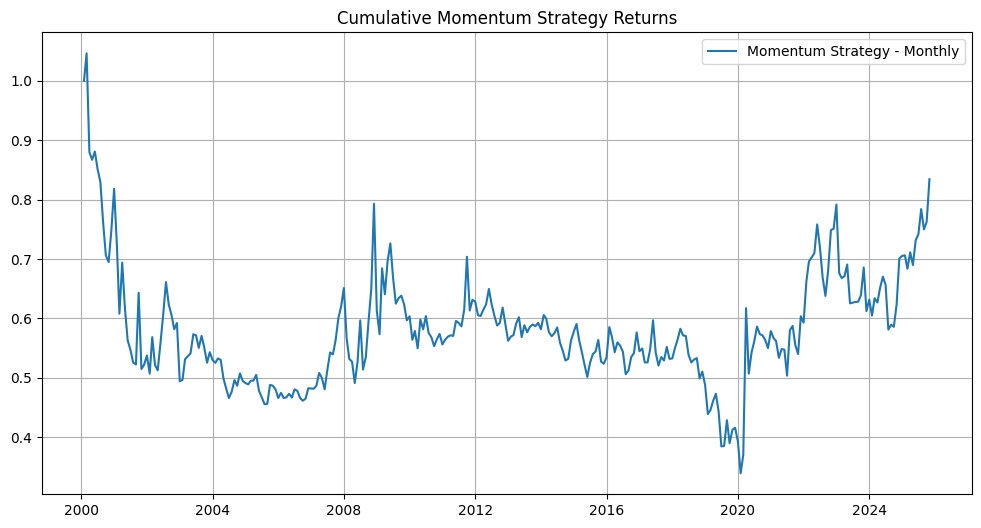

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_momentum_returns.cumsum() + 1, label='Momentum Strategy - Monthly')
plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
monthly_momentum_returns.mean()/monthly_momentum_returns.std()

np.float64(-0.013119967375430343)

### MACD Vol adjusted Strategy

In [29]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

In [30]:
for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()

In [31]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [32]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
df['macd_baz_signal'] = df.groupby('Date')['macd_baz_signal'].transform(compute_signal)

In [33]:
df['macd_tanh_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(np.tanh).sum(1).replace(0, np.nan)
df['macd_tanh_signal']  = df.groupby('Date')['macd_tanh_signal'].transform(compute_signal)

In [34]:
df['macd_baz_signal'] = df.groupby('Ticker')['macd_baz_signal'].shift()
df['macd_tanh_signal'] = df.groupby('Ticker')['macd_tanh_signal'].shift()

In [35]:
macd_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'baz': (x['macd_baz_signal'] * x['close_1d_ret']).sum()/70,
        'tanh': (x['macd_tanh_signal'] * x['close_1d_ret']).sum()/70
    })
)*1e-4

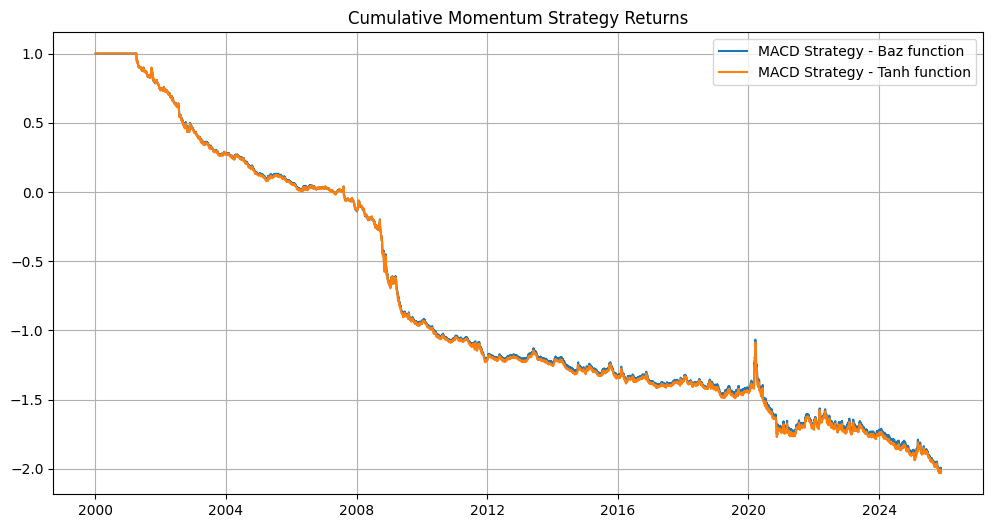

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(macd_daily_returns['baz'].cumsum() + 1, label='MACD Strategy - Baz function')
plt.plot(macd_daily_returns['tanh'].cumsum() + 1, label='MACD Strategy - Tanh function')

plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [37]:
macd_daily_returns.mean()/macd_daily_returns.std()*np.sqrt(252)

baz    -1.104998
tanh   -1.107917
dtype: float64

# Regress-then-rank Strategies 

In [5]:
df = pd.read_parquet('df_base.pq')

## Linear Regression

### Feature factory

In [41]:
with open("linear_features.pkl", "rb") as f:
    linear_features = pk.load(f)

In [42]:
all_linear_features = copy.deepcopy(linear_features)

In [43]:
for feature in tqdm(linear_features):
    for h in [3, 5, 10, 15, 20, 30, 60, 80]:
        df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
        df[f'zscore_{feature}_{h}d'] = (df[feature]-df[f'avg_{feature}_{h}d'])/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        all_linear_features.append(f'avg_{feature}_{h}d')
        all_linear_features.append(f'zscore_{feature}_{h}d')
        all_linear_features.append(f'sharpe_{feature}_{h}d')

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:38<01:15, 12.59s/it]/tmp/ipykernel_6480/3641886625.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'zscore_{feature}_{h}d'] = (df[feature]-df[f'avg_{feature}_{h}d'])/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
/tmp/ipykernel_6480/3641886625.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
 44%|████▍     | 4/9 [00:51<01:03, 12.62s/it]/tmp/ipyke

In [44]:
df.to_parquet('df_all_features.pq')

In [45]:
with open("all_linear_features.pkl", "wb") as f:
    pk.dump(all_linear_features, f)

### Article features

In [2]:
df = pd.read_parquet('df_base.pq')

In [3]:
article_features = []

feature = 'close_1d_ret'
for h in [3, 5, 20, 60]:
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[f'avg_{feature}_{h}d'].shift()
    df[f'vol_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())*np.sqrt(252)
    df[f'vol_{h}d'] = df.groupby('Ticker')[f'vol_{h}d'].shift()
    df[f'avg_normalised_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df[f'vol_{h}d']
    article_features.append(f'avg_{feature}_{h}d')
    article_features.append(f'avg_normalised_{feature}_{h}d')

#### Test for MACD Features

In [ ]:
test_df = df[['Ticker']]
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]
for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
        macd_adj_series.name = f'macd_adj_first_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_first_{window}_{i+1}'] /= test_df[f'macd_adj_first_{window}_{i+1}'].rolling(window).std()

for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(window).std()
        macd_adj_series.name = f'macd_adj_second_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_second_{window}_{i+1}'] /= test_df[f'macd_adj_second_{window}_{i+1}'].rolling(252).std()

100%|██████████| 4/4 [00:32<00:00,  8.01s/it]


In [ ]:
test_df.drop(columns='Ticker').corr()

,macd_adj_first_21_1,macd_adj_first_21_2,macd_adj_first_21_3,macd_adj_first_63_1,macd_adj_first_63_2,macd_adj_first_63_3,macd_adj_first_126_1,macd_adj_first_126_2,macd_adj_first_126_3,macd_adj_first_252_1,...,macd_adj_second_21_3,macd_adj_second_63_1,macd_adj_second_63_2,macd_adj_second_63_3,macd_adj_second_126_1,macd_adj_second_126_2,macd_adj_second_126_3,macd_adj_second_252_1,macd_adj_second_252_2,macd_adj_second_252_3
macd_adj_first_21_1,1.000000,0.862448,0.544222,0.960550,0.848635,0.596267,0.951997,0.837783,0.585889,0.949976,...,0.579770,0.949976,0.833573,0.575704,0.928337,0.814925,0.564625,0.911329,0.800540,0.555165
macd_adj_first_21_2,0.862448,1.000000,0.822700,0.821791,0.942424,0.837304,0.814090,0.934597,0.838068,0.812094,...,0.852135,0.812094,0.933049,0.834615,0.793941,0.912427,0.818102,0.779571,0.896405,0.804267
macd_adj_first_21_3,0.544222,0.822700,1.000000,0.526924,0.768294,0.915679,0.523233,0.761163,0.907902,0.521071,...,0.937931,0.521071,0.759594,0.910464,0.509796,0.743146,0.890182,0.500556,0.730411,0.875356
macd_adj_first_63_1,0.960550,0.821791,0.526924,1.000000,0.878665,0.612981,0.987832,0.862525,0.598377,0.984285,...,0.560497,0.984285,0.855684,0.585666,0.953605,0.829396,0.569586,0.934678,0.813598,0.559381
macd_adj_first_63_2,0.848635,0.942424,0.768294,0.878665,1.000000,0.873316,0.868632,0.984113,0.863105,0.865467,...,0.826703,0.865467,0.978482,0.853231,0.839060,0.948841,0.829472,0.822363,0.930568,0.814193
macd_adj_first_63_3,0.596267,0.837304,0.915679,0.612981,0.873316,1.000000,0.608304,0.861981,0.974059,0.605875,...,0.945715,0.605875,0.857235,0.966571,0.587883,0.831937,0.937928,0.576041,0.815984,0.920777
macd_adj_first_126_1,0.951997,0.814090,0.523233,0.987832,0.868632,0.608304,1.000000,0.874801,0.606877,0.994757,...,0.563234,0.994757,0.866435,0.592892,0.977363,0.851635,0.584757,0.953403,0.831473,0.571655
macd_adj_first_126_2,0.837783,0.934597,0.761163,0.862525,0.984113,0.861981,0.874801,1.000000,0.879208,0.870312,...,0.834585,0.870312,0.992613,0.866931,0.855273,0.975333,0.853965,0.834300,0.952048,0.834405
macd_adj_first_126_3,0.585889,0.838068,0.907902,0.598377,0.863105,0.974059,0.606877,0.879208,1.000000,0.603716,...,0.960619,0.603716,0.873339,0.988161,0.593846,0.858495,0.971385,0.579189,0.838055,0.949056
macd_adj_first_252_1,0.949976,0.812094,0.521071,0.984285,0.865467,0.605875,0.994757,0.870312,0.603716,1.000000,...,0.564741,1.000000,0.872006,0.596576,0.988100,0.861958,0.591770,0.970893,0.847576,0.582688


#### End

In [4]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()
    df[f'macd_adj_{i+1}'] = df.groupby('Ticker')[f'macd_adj_{i+1}'].shift()
    article_features.append(f'macd_adj_{i+1}')

In [5]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [6]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
article_features.append('macd_baz_signal')

In [7]:
df[article_features].corr()

,avg_close_1d_ret_3d,avg_normalised_close_1d_ret_3d,avg_close_1d_ret_5d,avg_normalised_close_1d_ret_5d,avg_close_1d_ret_20d,avg_normalised_close_1d_ret_20d,avg_close_1d_ret_60d,avg_normalised_close_1d_ret_60d,macd_adj_1,macd_adj_2,macd_adj_3,macd_baz_signal
avg_close_1d_ret_3d,1.000000,0.126458,0.765622,0.545510,0.383220,0.318219,0.213118,0.191727,0.740033,0.667325,0.538856,0.662796
avg_normalised_close_1d_ret_3d,0.126458,1.000000,0.096575,0.143272,0.048090,0.060642,0.029230,0.035975,0.129930,0.116349,0.093217,0.124767
avg_close_1d_ret_5d,0.765622,0.096575,1.000000,0.711844,0.494570,0.407940,0.274844,0.245965,0.694982,0.728644,0.635995,0.711751
avg_normalised_close_1d_ret_5d,0.545510,0.143272,0.711844,1.000000,0.348215,0.436107,0.205546,0.254342,0.689446,0.719866,0.626097,0.749206
avg_close_1d_ret_20d,0.383220,0.048090,0.494570,0.348215,1.000000,0.812535,0.556924,0.480659,0.185727,0.464462,0.678852,0.464888
avg_normalised_close_1d_ret_20d,0.318219,0.060642,0.407940,0.436107,0.812535,1.000000,0.456159,0.554197,0.213253,0.530894,0.776620,0.546932
avg_close_1d_ret_60d,0.213118,0.029230,0.274844,0.205546,0.556924,0.456159,1.000000,0.841362,0.024235,0.083042,0.284539,0.118264
avg_normalised_close_1d_ret_60d,0.191727,0.035975,0.245965,0.254342,0.480659,0.554197,0.841362,1.000000,0.035525,0.107066,0.343867,0.151938
macd_adj_1,0.740033,0.129930,0.694982,0.689446,0.185727,0.213253,0.024235,0.035525,1.000000,0.871973,0.596388,0.842705
macd_adj_2,0.667325,0.116349,0.728644,0.719866,0.464462,0.530894,0.083042,0.107066,0.871973,1.000000,0.875307,0.953214


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [21]:
class Winsorizer(BaseEstimator, TransformerMixin):
    """
    Transformateur pour winsoriser les features.
    Les limites sont apprises sur le train set et appliquées au test set.
    """
    def __init__(self, lower=0.01, upper=0.01):
        self.lower = lower
        self.upper = upper
        self.lower_bounds_ = None
        self.upper_bounds_ = None
    
    def fit(self, X, y=None):
        """Apprend les limites de winsorisation sur X"""
        if isinstance(X, pd.DataFrame):
            self.lower_bounds_ = X.quantile(self.lower)
            self.upper_bounds_ = X.quantile(1 - self.upper)
            self.feature_names_ = X.columns
        else:
            # Pour numpy array
            self.lower_bounds_ = np.percentile(X, self.lower * 100, axis=0)
            self.upper_bounds_ = np.percentile(X, (1 - self.upper) * 100, axis=0)
        
        return self
    
    def transform(self, X):
        """Applique la winsorisation avec les limites apprises"""
        if self.lower_bounds_ is None or self.upper_bounds_ is None:
            raise ValueError("Winsorizer must be fitted before transform")
        
        X_copy = X.copy()
        
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                X_copy[col] = np.clip(X_copy[col], 
                                     self.lower_bounds_[col], 
                                     self.upper_bounds_[col])
        else:
            # Pour numpy array
            X_copy = np.clip(X_copy, self.lower_bounds_, self.upper_bounds_)
        
        return X_copy

In [10]:
X = df[article_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[article_features]
y = df[article_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"]

split_date = X.index.unique()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [51]:
ols_baseline = Pipeline([
    ('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
    ('reg', LinearRegression(fit_intercept=False))
])

In [12]:
ols_baseline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('winsorizer', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,lower,0.001
,upper,0.001
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",False
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [13]:
X_train.columns

Index(['avg_close_1d_ret_3d', 'avg_normalised_close_1d_ret_3d',
       'avg_close_1d_ret_5d', 'avg_normalised_close_1d_ret_5d',
       'avg_close_1d_ret_20d', 'avg_normalised_close_1d_ret_20d',
       'avg_close_1d_ret_60d', 'avg_normalised_close_1d_ret_60d', 'macd_adj_1',
       'macd_adj_2', 'macd_adj_3', 'macd_baz_signal'],
      dtype='object')

In [14]:
ols_baseline.named_steps['reg'].coef_

array([ 1.19270315e-02, -1.16562397e+01, -7.12169534e-02, -3.26068433e+01,
        5.06027099e-02, -6.44415680e+01, -3.17904975e-01,  1.12414783e+03,
       -7.71433184e+00,  6.02827662e+00, -9.58260433e+00,  6.51685665e+00])

In [15]:
y_pred = ols_baseline.predict(X_test)

In [16]:
df_test = df[df.index>=split_date][article_features + ["Ticker", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret"]]
# df_test = df[df.index>=split_date].replace([-np.inf, np.inf], np.nan).dropna()

In [17]:
df_test['y_pred'] = y_pred

In [4]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0))
    return signal

In [19]:
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)

In [20]:
ols_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

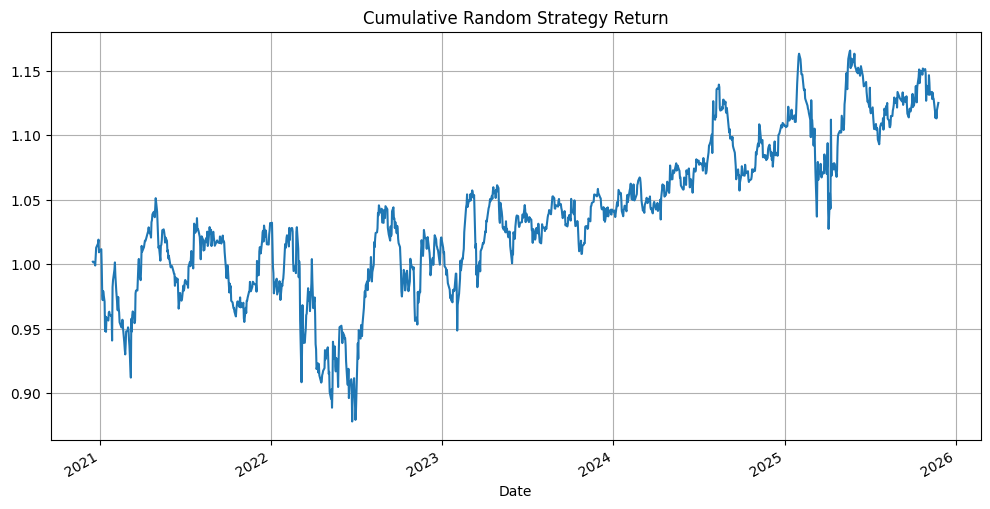

In [21]:
(ols_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [22]:
ols_daily_returns.mean()/ols_daily_returns.std()

np.float64(0.011362465708198512)

### All features

In [5]:
from sklearn.decomposition import PCA

In [6]:
with open("all_linear_features.pkl", "rb") as f:
    all_linear_features = pk.load(f)

In [7]:
df = pd.read_parquet('df_all_features.pq')

In [49]:
X = df[all_linear_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[all_linear_features]
y = df[all_linear_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"]

split_date = X.index.unique()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [52]:
ols_baseline.fit(X_train.to_numpy(), y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('winsorizer', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,lower,0.001
,upper,0.001
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",False
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [53]:
y_pred = ols_baseline.predict(X_test.to_numpy())
df_test = df[df.index>=split_date][all_linear_features + ["Ticker", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret"]]
df_test['y_pred'] = y_pred

In [54]:
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
ols_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

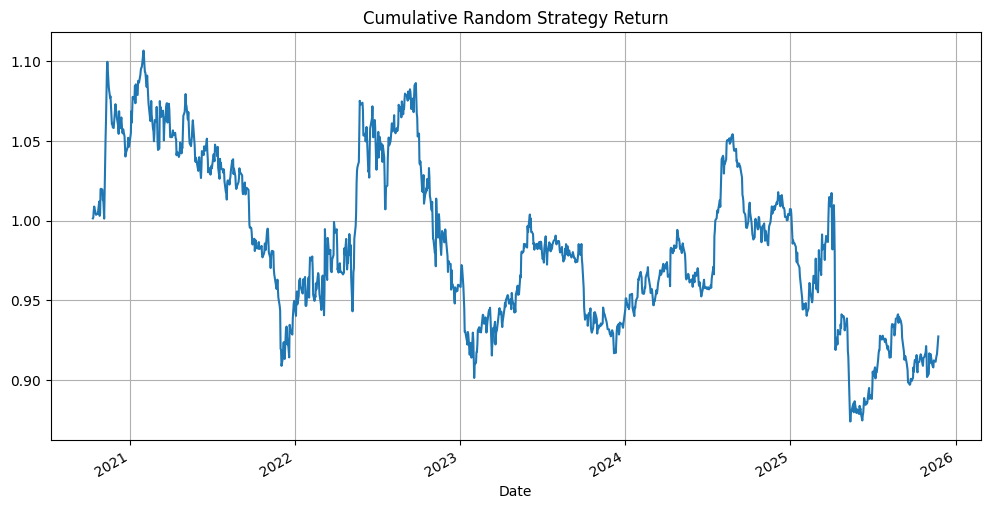

In [55]:
(ols_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [56]:
ols_daily_returns.mean()/ols_daily_returns.std()

np.float64(-0.00806906234459942)

In [57]:
ols_pca = Pipeline([
    ('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
    ('pca', PCA(n_components=0.95)),
    ('reg', LinearRegression(fit_intercept=False))
])

In [58]:
ols_pca.fit(X_train.to_numpy(), y_train)
y_pred_pca = ols_pca.predict(X_test.to_numpy())
df_test = df[df.index>=split_date][all_linear_features + ["Ticker", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret"]]
df_test['y_pred'] = y_pred_pca
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
ols_pca_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

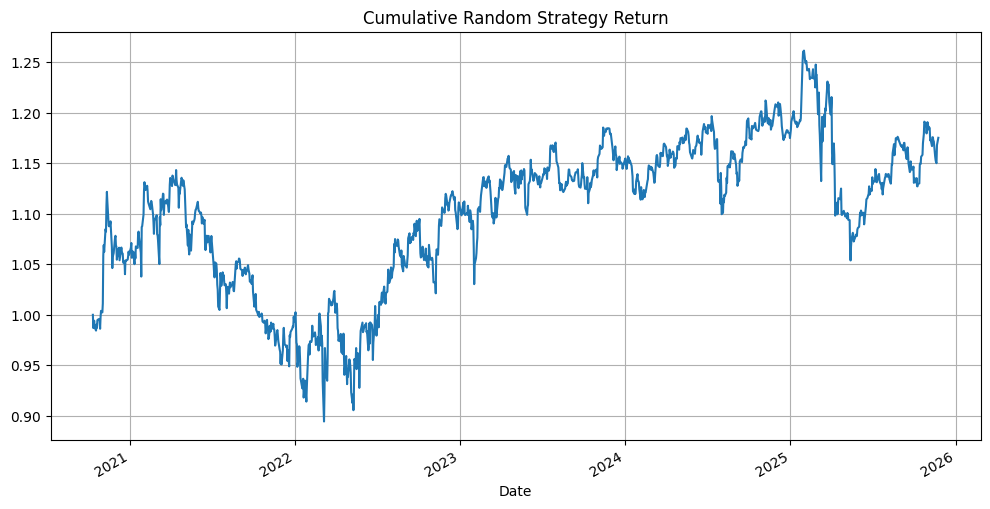

In [59]:
(ols_pca_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [60]:
ols_pca_daily_returns.mean()/ols_pca_daily_returns.std()

np.float64(0.013711577193895047)

## LGBM Regressor

In [22]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [23]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [24]:
df = pd.read_parquet('df_all_features.pq')

#### Non linear features

In [25]:
import pickle as pkl

In [26]:
with open("non_linear_features.pkl", "rb") as f:
    non_linear_features = pkl.load(f)

In [27]:
all_features = all_linear_features + non_linear_features

In [28]:
for window in tqdm([5, 10, 21, 42, 63, 126, 252]):
    df[f'vol_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).std().shift())
    df[f'kurt_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).kurt().shift())
    df[f'skew_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).skew().shift())
    all_features.append(f'vol_{window}d')
    all_features.append(f'kurt_{window}d')
    all_features.append(f'skew_{window}d')
    if window>=10:
        df[f'vol_upside_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.where(x>0, 0).rolling(window).std().shift())
        df[f'vol_downside_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.where(x<0, 0).rolling(window).std().shift())
        all_features.append(f'vol_upside_{window}d')
        all_features.append(f'vol_downside_{window}d')

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:21<00:00,  3.06s/it]


#### End

In [29]:
len(all_features)

260

In [30]:
X = df[all_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[all_features]
y = df[all_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"]

split_date = X.index.unique()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [74]:
lgbm = Pipeline([
    # ('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
    ('pca', PCA(n_components=0.95)),
    ('model', LGBMRegressor(
        objective="regression",
        boosting_type="gbdt",
        random_state=42,
        n_jobs=-1
    ))
])

In [32]:
%%time 
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2083719, number of used features: 2
[LightGBM] [Info] Start training from score 4.506494
CPU times: user 18.8 s, sys: 613 ms, total: 19.5 s
Wall time: 7.45 s


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pca', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",0.95
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.l

In [33]:
y_pred_lgbm = lgbm.predict(X_test)

/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [34]:
df_test = df[df.index>=split_date][all_features + ["Ticker", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret"]]

In [35]:
df_test['y_pred'] = y_pred_lgbm

In [36]:
df_test['lgbm_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
lgbm_daily_returns = df_test.groupby('Date').apply(lambda x: (x['lgbm_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

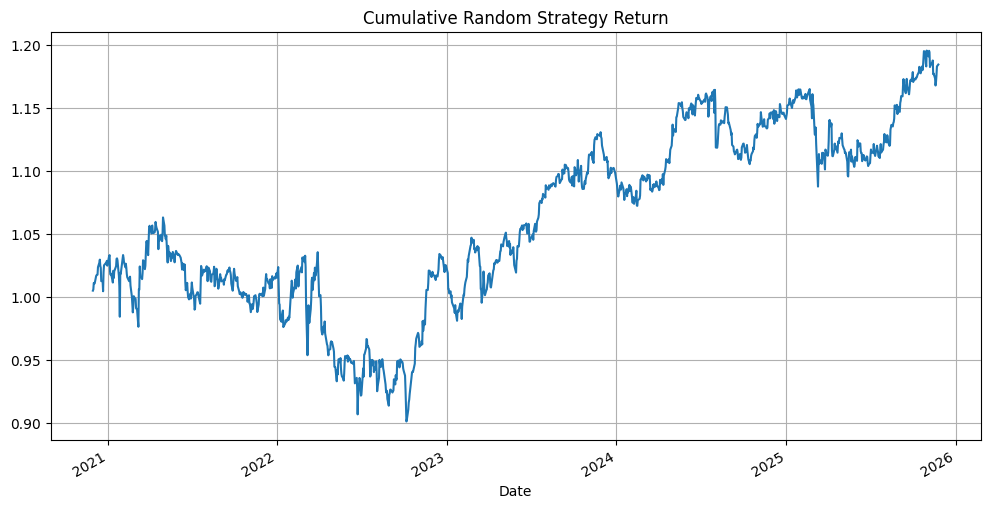

In [37]:
(lgbm_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [38]:
lgbm_daily_returns.mean()/lgbm_daily_returns.std()

np.float64(0.024208869723804073)

In [93]:
%pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.6 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [105]:
from sklearn.model_selection._split import _BaseKFold

In [111]:
class ExpandingWindowCV(_BaseKFold):
    """
    Expanding Window Cross-Validator with fixed test size based on unique dates.
    
    This cross-validator creates splits where:
    - Split 1: Train on first 50% of unique dates, test on next 15% of unique dates
    - Split 2: Train on first 65% of unique dates, test on next 15% of unique dates
    - Split 3: Train on first 85% of unique dates, test on last 15% of unique dates
    
    The DataFrame is expected to be indexed by dates, with potentially multiple rows per date.
    The split is performed on unique dates, and all rows corresponding to dates in the 
    train/test periods are included in the respective sets.
    
    Parameters
    ----------
    n_splits : int, default=3
        Number of folds (fixed at 3 for this implementation)
    """
    
    def __init__(self, n_splits=3):
        super().__init__(n_splits=n_splits, shuffle=False, random_state=None)
        if n_splits != 3:
            raise ValueError("This implementation is designed for exactly 3 splits")
    
    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and test set based on unique dates.
        
        Parameters
        ----------
        X : pandas DataFrame with DatetimeIndex
            Training data indexed by dates
        y : array-like of shape (n_samples,), default=None
            Target variable
        groups : array-like of shape (n_samples,), default=None
            Group labels (not used)
            
        Yields
        ------
        train : ndarray
            The training set indices for that split
        test : ndarray
            The testing set indices for that split
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame with DatetimeIndex")
        
        if not isinstance(X.index, pd.DatetimeIndex):
            raise TypeError("X must have a DatetimeIndex")
        
        # Get unique dates and sort them
        unique_dates = pd.Series(X.index.unique()).sort_values().values
        n_unique_dates = len(unique_dates)
        
        # Define train/test boundaries as percentages of unique dates
        splits_config = [
            (0.50, 0.65),  # Train: 0-50%, Test: 50-65%
            (0.65, 0.80),  # Train: 0-65%, Test: 65-80%
            (0.85, 1.00),  # Train: 0-85%, Test: 85-100%
        ]
        
        for train_end_pct, test_end_pct in splits_config:
            train_end_idx = int(np.floor(train_end_pct * n_unique_dates))
            test_end_idx = int(np.floor(test_end_pct * n_unique_dates))
            
            # Get the date boundaries
            train_dates = unique_dates[:train_end_idx]
            test_dates = unique_dates[train_end_idx:test_end_idx]
            
            # Get all row indices corresponding to these dates
            train_indices = np.where(X.index.isin(train_dates))[0]
            test_indices = np.where(X.index.isin(test_dates))[0]
            
            yield train_indices, test_indices
    
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator"""
        return self.n_splits

In [112]:
cv = ExpandingWindowCV(n_splits=3)

In [ ]:
param_distributions = {
    'model__num_leaves': [20, 31, 50, 75],
    'model__learning_rate': [0.01, 0.03, 0.05],
    'model__n_estimators': [300, 500, 700],

    'model__min_child_samples': [50, 100, 150, 200],
    'model__min_child_weight': [0.001, 0.01, 0.1, 1],
    'model__reg_alpha': [0.1, 1, 5, 10],
    'model__reg_lambda': [0.1, 1, 5, 10],

    'model__subsample': [0.7, 0.8, 0.85],
    'model__subsample_freq': [1],
    'model__colsample_bytree': [0.7, 0.8, 0.85],

    'model__max_depth': [5, 7, 9],
}

In [119]:
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=300,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=1,
    verbose=1,
    random_state=42
)

In [ ]:
%%time
random_search.fit(X_train, y_train)

In [123]:
with open("random_search.pkl", "wb") as f:
    pkl.dump(random_search, f)

In [125]:
import seaborn as sns

In [133]:
import math

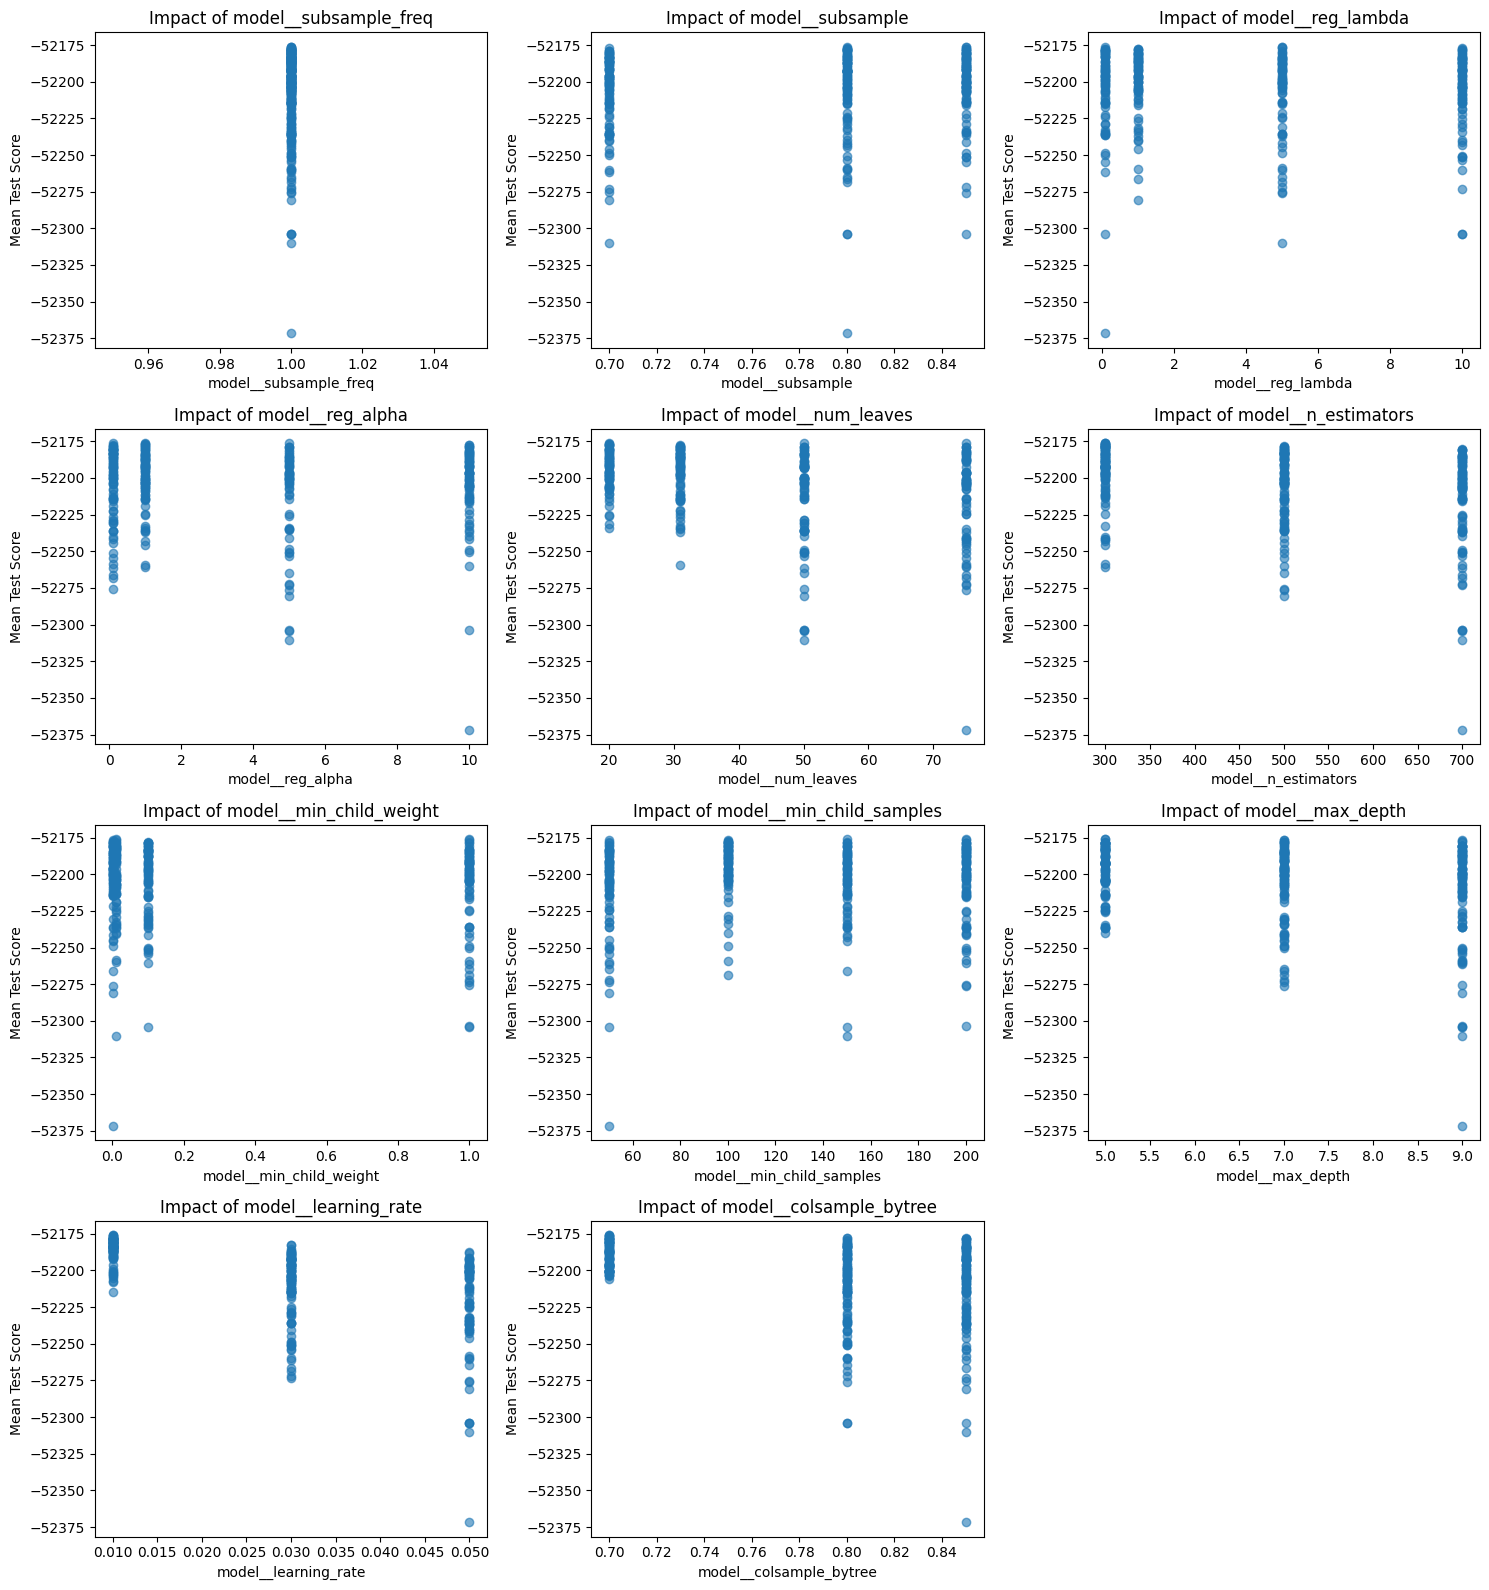

In [137]:
results_df = pd.DataFrame(random_search.cv_results_)

# Extract parameter columns
param_cols = [col for col in results_df.columns if col.startswith('param_')]

# Create clean dataframe
plot_df = results_df[param_cols + ['mean_test_score', 'std_test_score']].copy()
plot_df.columns = [col.replace('param_', '') for col in plot_df.columns]

# Parameters to plot
params = [col for col in plot_df.columns if col not in ['mean_test_score', 'std_test_score']]
n_params = len(params)

# Dynamic subplot grid
n_cols = 3
n_rows = math.ceil(n_params / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, param in enumerate(params):
    ax = axes[idx]
    ax.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)
    ax.set_xlabel(param)
    ax.set_ylabel('Mean Test Score')
    ax.set_title(f'Impact of {param}')

# Remove unused subplots
for idx in range(len(params), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [140]:
second_param_distributions = {
    'model__num_leaves': [10, 15, 20, 31],
    'model__learning_rate': [0.05, 0.01, 0.02],
    'model__n_estimators': [150, 200, 300, 400, 500],

    'model__min_child_samples': [80, 100, 120, 200, 300],
    'model__min_child_weight': [0.01, 0.1, 0.2, 0.5],
    'model__reg_alpha': [0.1, 1, 2, 3, 5],
    'model__reg_lambda': [1, 3, 10, 15, 20],

    'model__subsample': [0.7, 0.8, 0.85],
    'model__subsample_freq': [1],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.75],

    'model__max_depth': [3, 5],
}

In [141]:
second_random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=second_param_distributions,
    n_iter=300,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=1,
    verbose=1,
    random_state=42
)

In [ ]:
second_random_search.fit(X_train, y_train)

In [143]:
with open("second_random_search.pkl", "wb") as f:
    pkl.dump(second_random_search, f)

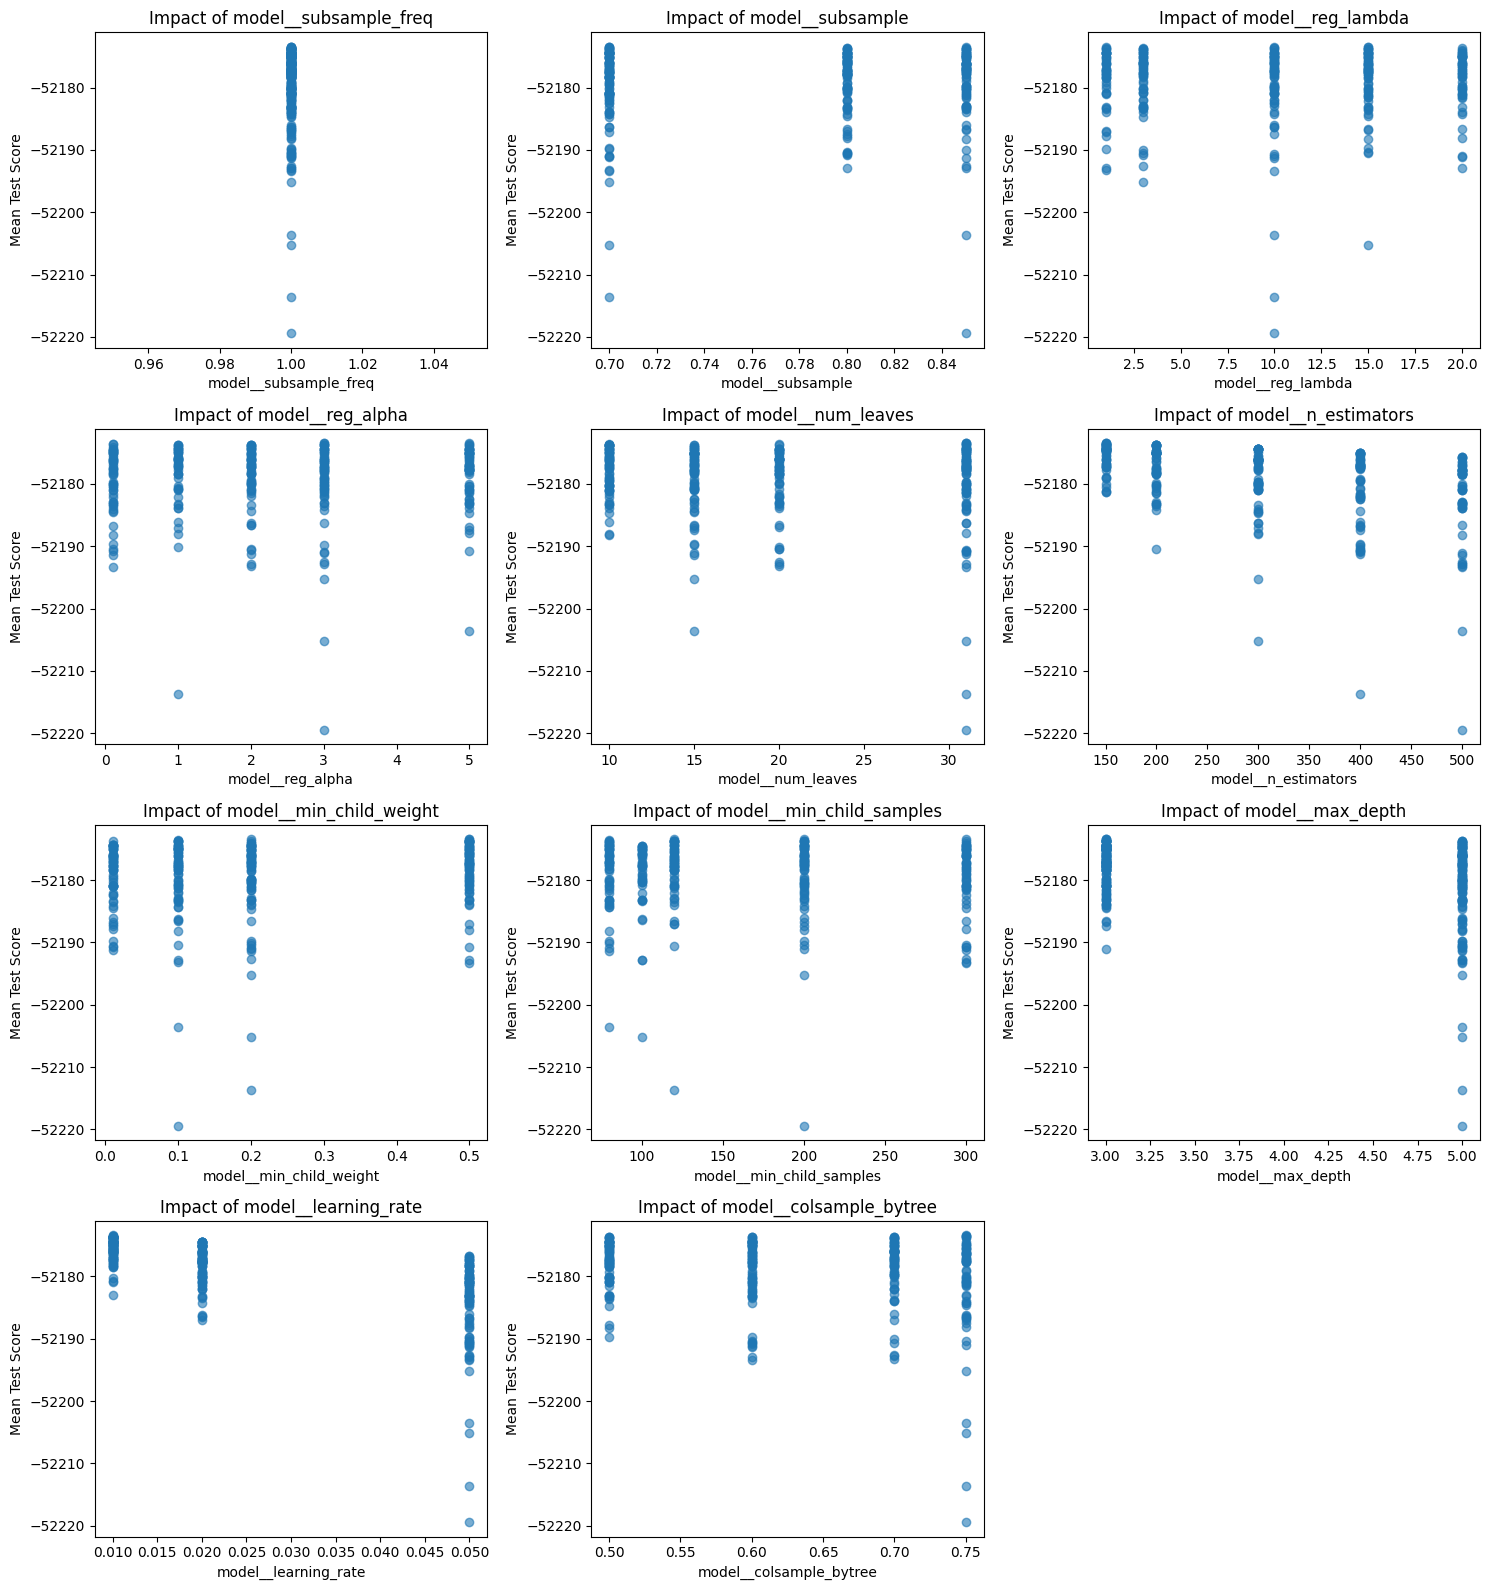

In [144]:
results_df = pd.DataFrame(second_random_search.cv_results_)

# Extract parameter columns
param_cols = [col for col in results_df.columns if col.startswith('param_')]

# Create clean dataframe
plot_df = results_df[param_cols + ['mean_test_score', 'std_test_score']].copy()
plot_df.columns = [col.replace('param_', '') for col in plot_df.columns]

# Parameters to plot
params = [col for col in plot_df.columns if col not in ['mean_test_score', 'std_test_score']]
n_params = len(params)

# Dynamic subplot grid
n_cols = 3
n_rows = math.ceil(n_params / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, param in enumerate(params):
    ax = axes[idx]
    ax.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)
    ax.set_xlabel(param)
    ax.set_ylabel('Mean Test Score')
    ax.set_title(f'Impact of {param}')

# Remove unused subplots
for idx in range(len(params), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()